In [306]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import seaborn as sns

# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке. Если в итоге по каким-то причинам тетрадка не будет открываться у преподавателя, задание не будет засчитано
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

In [271]:
!gdown 18PVwZWFbpRbEHW-Hc8R0DUTl9CF1aQa0 -O data.csv

Downloading...
From: https://drive.google.com/uc?id=18PVwZWFbpRbEHW-Hc8R0DUTl9CF1aQa0
To: /content/data.csv
100% 30.0M/30.0M [00:00<00:00, 274MB/s]


In [272]:
df = pd.read_csv('data.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

In [273]:
df.columns

Index(['manufacturer', 'price', 'number_available_in_stock',
       'number_of_reviews', 'number_of_answered_questions',
       'average_review_rating', 'amazon_category_and_sub_category'],
      dtype='object')

In [274]:
X, y = df.drop(columns=['price']), df.price

## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

In [275]:
df.shape

(8547, 7)

In [276]:
df.isna().sum()

manufacturer                           5
price                                  0
number_available_in_stock           2211
number_of_reviews                     15
number_of_answered_questions         673
average_review_rating                 15
amazon_category_and_sub_category     550
dtype: int64

**Мой текст:** Во всех признаках есть пропуски, удалим объекты, для которых больше 2х неизвестных признаков

In [277]:
df = df.drop(index=df[df.isna().sum(axis=1) > 2].index)

In [278]:
df = df.reset_index(drop=True)

In [279]:
df.isna().sum()

manufacturer                           4
price                                  0
number_available_in_stock           2201
number_of_reviews                     10
number_of_answered_questions         665
average_review_rating                 10
amazon_category_and_sub_category     536
dtype: int64

In [280]:
X, y = df.drop(columns=['price']), df.price

## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.

**Мой текст:** Лучше закодировать все категориальные признаки (amazon_category_and_sub_category) через one-hot, чтобы не приписывать никакую дополнительную иерархическую зависимость признакам. Признак number_available_in_stock можно разбить на 2: количество и состояние, еще на несколько признаков можно разбить amazon_category_and_sub_category: основная категория и все подкатегории

In [282]:
df_copy = df.copy()

# Переведем доступное количество в численное значение и отделим состояние в отдельный признак
df_copy[["number_available_in_stock", "condition"]] = df_copy["number_available_in_stock"].dropna().str.split(expand=True)
df_copy["number_available_in_stock"] = df_copy["number_available_in_stock"].dropna().astype(float)

# Переведем стоимость в численное значение
df_copy["price"] = df_copy["price"].str.replace('£', '').str.replace(',', '').astype(float)

# Переведем рейтинг в численное значение
df_copy["average_review_rating"] = df_copy["average_review_rating"].dropna().apply(lambda x: float(x.split()[0]))

# Переводим число отзывов в численное значение
df_copy["number_of_reviews"] = df_copy["number_of_reviews"].dropna().str.replace(',', '').astype(float)

# Переводим число ответов в численное значение
df_copy["number_of_answered_questions"] = df_copy["number_of_answered_questions"].dropna().astype(float)

# Заполняем пропуски по среднему и округляем там, где значения должны быть целыми
df_copy["average_review_rating"] = df_copy["average_review_rating"].fillna(np.mean(df_copy["average_review_rating"].dropna()))
df_copy["number_of_reviews"] = df_copy["number_of_reviews"].fillna(np.mean(df_copy["number_of_reviews"].dropna())).round(0)
df_copy["number_of_answered_questions"] = df_copy["number_of_answered_questions"].fillna(np.mean(df_copy["number_of_answered_questions"].dropna())).round(0)
df_copy["number_available_in_stock"] = df_copy["number_available_in_stock"].fillna(np.mean(df_copy["number_available_in_stock"].dropna()))

# Заполним пропуски в текстовых данных
df_copy[["manufacturer", "amazon_category_and_sub_category", "condition"]] = df_copy[["manufacturer", "amazon_category_and_sub_category", "condition"]].fillna("no information")

In [283]:
# Разделим amazon_category_and_sub_category на 5 признаков (тк максимум встречается 5 категорий) и заполним все пропуски
df_copy[["amazon_category", "1_sub_category", "2_sub_category", "3_sub_category", "4_sub_category"]] = df_copy["amazon_category_and_sub_category"].str.split(" > ", expand=True)
df_copy[["1_sub_category", "2_sub_category", "3_sub_category", "4_sub_category"]] = df_copy[["1_sub_category", "2_sub_category", "3_sub_category", "4_sub_category"]].fillna("no_category")
df_copy = df_copy.drop(columns=["amazon_category_and_sub_category"])

In [284]:
df_copy.isna().sum()

manufacturer                    0
price                           0
number_available_in_stock       0
number_of_reviews               0
number_of_answered_questions    0
average_review_rating           0
condition                       0
amazon_category                 0
1_sub_category                  0
2_sub_category                  0
3_sub_category                  0
4_sub_category                  0
dtype: int64

In [285]:
X, y = df_copy.drop(columns=['price']), df_copy.price

In [286]:
X_train, X_test, y_train, y_test = train_test_split(df_copy, y, train_size=0.65, random_state=42)

In [287]:
# Кодируем категориальные признаки

features = ["manufacturer", "condition", "amazon_category", "1_sub_category", "2_sub_category", "3_sub_category", "4_sub_category"]
X_encoded = X.copy()
encoder = OneHotEncoder(handle_unknown='ignore')
index_train = X_train.index
index_test = X_test.index

for feature in features:
  encoder.fit(X_train[[feature]])
  res = encoder.transform(X[[feature]])
  for string in encoder.categories_:
    arr = feature + "_" + string
  X_encoded = X_encoded.join(pd.DataFrame(res.toarray(), columns=arr))
  
X_encoded = X_encoded.drop(columns=features)
X_encoded.sample(10)

,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,manufacturer_16th Birthday 16th Foil Banner - 9ft,manufacturer_1st birthday,manufacturer_24 Game,"manufacturer_45"" Sunset Glow Pool",manufacturer_4M,manufacturer_50Fifty,...,3_sub_category_Vehicles,3_sub_category_Wagons,3_sub_category_Window Stickers,3_sub_category_Wooden Thomas,3_sub_category_no_category,4_sub_category_Figures,4_sub_category_Landscape Architecture,4_sub_category_Road Construction,4_sub_category_Track Construction,4_sub_category_no_category
1574,3.000000,3.0,1.0,4.3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6872,3.000000,2.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5305,3.000000,9.0,2.0,4.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5533,8.735471,2.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3030,5.000000,3.0,1.0,4.7,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3160,5.000000,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2237,8.735471,1.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4075,7.000000,21.0,1.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
956,7.000000,2.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2807,7.000000,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [288]:
X_encoded_train = X_encoded.iloc[X_train.index, :]
y_encoded_train = y[X_train.index]
X_encoded_test = X_encoded.iloc[X_test.index, :]
y_encoded_test = y[X_test.index]

# Обучение модели (3 балла)

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

In [292]:
dummy = DummyRegressor()
dummy.fit(X_encoded_train, y_encoded_train)

DummyRegressor()

In [293]:
y_pred = dummy.predict(X_encoded_test)
print("MSE: ", mse(y_encoded_test, y_pred))
print("RMSE: ", mse(y_encoded_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_encoded_test, y_pred))

MSE:  1705.68209137284
RMSE:  41.29990425379749
r2_score:  -0.00017061319390720975


## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.

In [294]:
tree = DecisionTreeRegressor()
tree.fit(X_encoded_train, y_encoded_train)
y_pred = tree.predict(X_encoded_test)

print("MSE: ", mse(y_encoded_test, y_pred))
print("RMSE: ", mse(y_encoded_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_encoded_test, y_pred))

MSE:  2325.271802663537
RMSE:  48.22107218492282
r2_score:  -0.36348299397377604


**Мой текст:** качество ухудшилось

## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

In [296]:
lin_reg = LinearRegression()
lin_reg.fit(X_encoded_train, y_encoded_train)
y_pred = lin_reg.predict(X_encoded_test)

print("MSE: ", mse(y_encoded_test, y_pred))
print("RMSE: ", mse(y_encoded_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_encoded_test, y_pred))

MSE:  3.991500668451647e+19
RMSE:  6317832435.615594
r2_score:  -2.3405191924809476e+16


# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

In [307]:
def plot_fitting_curve(parameter: str, values: list, X_train, X_test, y_train, y_test, name='title', xlabel='xlabel', ylabel='ylabel'):
    train_curve = []
    test_curve = []
    for value in values:
        model = DecisionTreeRegressor(**{parameter: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(mse(y_train, y_pred_train))
        test_curve.append(mse(y_test, y_pred_test))
    sns.lineplot(x=values, y=train_curve, label='train').set(title=name, xlabel=xlabel, ylabel=ylabel)
    sns.lineplot(x=values, y=test_curve, label='test')

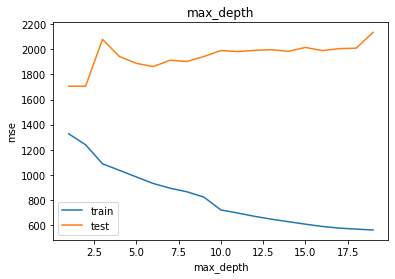

In [310]:
plot_fitting_curve('max_depth', np.arange(1, 20), X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test, 'max_depth', 'max_depth', 'mse')

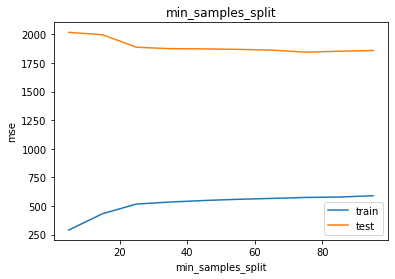

In [312]:
plot_fitting_curve('min_samples_split', np.arange(5, 100, 10), X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test, 'min_samples_split', 'min_samples_split', 'mse')

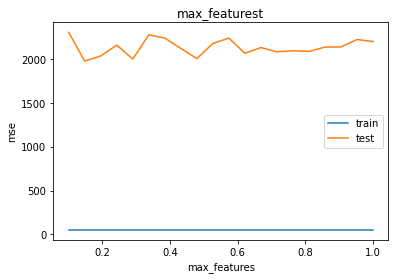

In [314]:
plot_fitting_curve('max_features', np.linspace(0.1, 1, 20), X_encoded_train, X_encoded_test, y_train, y_test, 'max_featurest', 'max_features', 'mse')

In [316]:
tree = DecisionTreeRegressor(max_depth=6, min_samples_split=20, max_features=0.35)
tree.fit(X_encoded_train, y_encoded_train)
y_pred = tree.predict(X_encoded_test)

print("MSE: ", mse(y_encoded_test, y_pred))
print("RMSE: ", mse(y_encoded_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_encoded_test, y_pred))

MSE:  1875.6495087273838
RMSE:  43.30876942060792
r2_score:  -0.09983538478194398


**Мой текст:** модель начинает переобучаться примерно  с глубины 10

# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [346]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self._num_trees = num_trees
        self._samples_frac = samples_frac
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]

    def fit(self, x: pd.DataFrame, y: pd.Series):
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=42)
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)

    def predict(self, x: pd.DataFrame):
        res = []
        for i in range(self._num_trees):
          res.append(self._trees[i].predict(x))
        return sum(res) / len(res)

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.

In [347]:
etr = EnsembleTreeRegressor()
etr.fit(X_encoded_train, y_encoded_train)
y_pred = etr.predict(X_encoded_test)

print("MSE: ", mse(y_encoded_test, y_pred))
print("RMSE: ", mse(y_encoded_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_encoded_test, y_pred))

MSE:  1667.2488288564136
RMSE:  40.83195842543453
r2_score:  0.022365719885112156


**Мой текст:** ансамбль работает лучше

In [360]:
def etr_plot_fitting_curve(parameter: str, values: list, X_train, X_test, y_train, y_test, name='title', xlabel='xlabel', ylabel='ylabel', num_trees=5, samples_frac=0.8):
    train_curve = []
    test_curve = []
    for value in values:
        model = EnsembleTreeRegressor(**{parameter: value}, num_trees=num_trees, samples_frac=samples_frac)
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(mse(y_train, y_pred_train))
        test_curve.append(mse(y_test, y_pred_test))
    sns.lineplot(x=values, y=train_curve, label='train').set(title=name, xlabel=xlabel, ylabel=ylabel)
    sns.lineplot(x=values, y=test_curve, label='test')

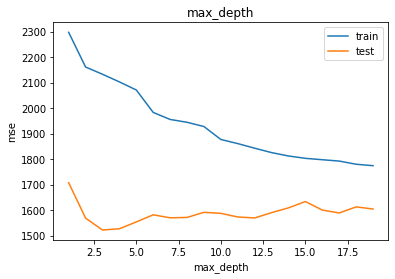

In [361]:
etr_plot_fitting_curve('max_depth', np.arange(1, 20), X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test, 'max_depth', 'max_depth', 'mse')

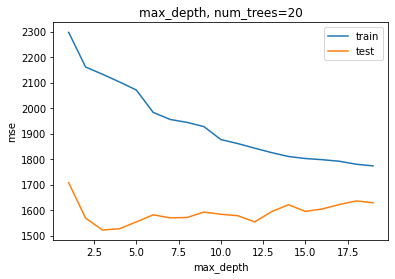

In [362]:
etr_plot_fitting_curve('max_depth', np.arange(1, 20), X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test, 'max_depth, num_trees=20', 'max_depth', 'mse', num_trees=20)

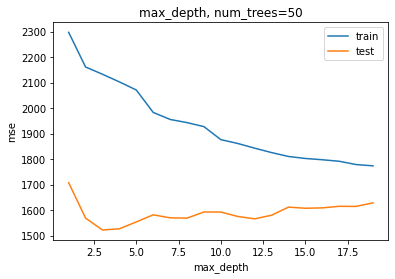

In [363]:
etr_plot_fitting_curve('max_depth', np.arange(1, 20), X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test, 'max_depth, num_trees=50', 'max_depth', 'mse', num_trees=50)

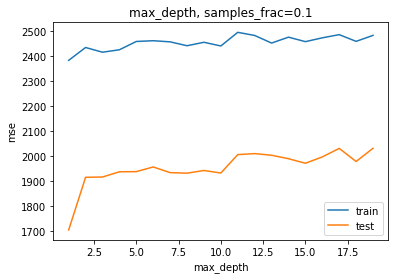

In [364]:
etr_plot_fitting_curve('max_depth', np.arange(1, 20), X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test, 'max_depth, samples_frac=0.1', 'max_depth', 'mse', samples_frac=0.1)

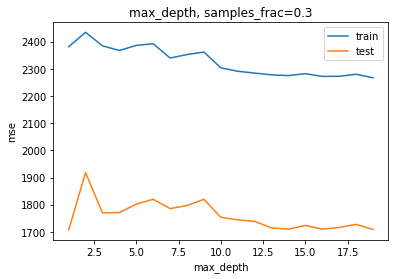

In [365]:
etr_plot_fitting_curve('max_depth', np.arange(1, 20), X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test, 'max_depth, samples_frac=0.3', 'max_depth', 'mse', samples_frac=0.3)

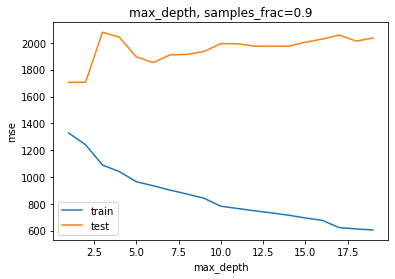

In [366]:
etr_plot_fitting_curve('max_depth', np.arange(1, 20), X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test, 'max_depth, samples_frac=0.9', 'max_depth', 'mse', samples_frac=0.9)

**Мой текст:** модель переобучается примерно при глубине 13-15. Сильной зависимости от других признаков нет 

In [367]:
etr = EnsembleTreeRegressor(max_depth=3, num_trees=5, samples_frac=0.3)
etr.fit(X_encoded_train, y_encoded_train)
y_pred = etr.predict(X_encoded_test)

print("MSE: ", mse(y_encoded_test, y_pred))
print("RMSE: ", mse(y_encoded_test, y_pred, squared=False))
print("r2_score: ", r2_score(y_encoded_test, y_pred))

MSE:  1770.2449021954803
RMSE:  42.07427839185694
r2_score:  -0.03802867972143309
